In [1]:
#
# Dx Library Portfolio
# derivatives_portfolio.py
#
import numpy as np
import pandas as pd

from dx import *

#위험 요인 모형화에 필요한 모형
models = {'gbm' : geometric_brownian_motion,
         'jd' : jump_diffusion,
         'srd' : square_root_diffusion}

# 행사 유형
otypes = {'European' : valuation_mcs_european,
         'American' : valuation_mcs_american}

class derivatives_portfolio(object):
    '''
    파생상품 포지션 포트폴리오 생성용 클래스
    속성
    ====
    name : str
        객체 이름
    positions : dict
        포지션용 사전
    val_env : market_environment
        가치 평가용 시장 환겨
    assets : dict
        각 자산용 시장 환경 사전
    correlations : list
        자산 간의 상관 관계
    fixed_seed : Boolean
        랜덤 변수용 시드 플래그
    
    메서드
    ====
    get_positions :
        포트폴리오의 단일 포지션에 대한 정보 출력
    get_statistics :
        포트폴리오 통계를 pandas Dataframe 객체로 출력
    '''
    
    def __init__(self,name,positions,val_env,assets,
                correlations = None, fixed_seed = False):
        self.name = name
        self.positions = positions
        self.val_env = val_env
        self.assets = assets
        self.underlyings = set()
        self.correlations = correlations
        self.time_grid = None
        self.underlying_objects = {}
        self.valuation_objects = {}
        self.fixed_seed = fixed_seed
        self.special_dates = []
        for pos in self.positions:
            #가장 빠른 starting_date 결정
            self.val_env.constants['starting_date']= min(self.val_env.constants['starting_date'],positions[pos].mar_env.pricing_date)
            #관련 있는 최신 날짜 설정
            self.val_env.constants['final_date'] = max(self.val_env.constants['final_date'],
                                                      positions[pos].mar_env.constants['maturity'])
            #모든 기초자산을 집합으로 모아 중복 제거
            self.underlyings.add(positions[pos].underlying)
        # time grid 생성
        start = self.val_env.constants['starting_date']
        end = self.val_env.constants['final_date']
        time_grid = pd.date_range(start = start,end = end, freq = self.val_env.constants['frequency']).to_pydatetime()
        time_grid = list(time_grid)
        for pos in self.positions:
            maturity_date = positions[pos].mar_env.constants['maturity']
            if maturity_date not in time_grid:
                time_grid.insert(0,maturity_date)
                self.special_dates.append(maturity_date)
        if start not in time_grid:
            time_grid.insert(0,start)
        if end not in time_grid:
            time_grid.append(end)
        #중복 제거
        time_grid = list(set(time_grid))
        #time_grid 안 날짜 정렬
        time_grid.sort()
        self.time_grid = np.array(time_grid)
        self.val_env.add_list('time_grid',self.time_grid)
        if correlations is not None:
            #상관관계 계산
            ul_list = sorted(self.underlyings)
            correlation_matrix = np.zeros((len(ul_list),len(ul_list)))
            np.fill_diagonal(correlation_matrix,1.0)
            correlation_matrix = pd.DataFrame(correlation_matrix,
                            index = ul_list,columns = ul_list)
            for i,j ,corr in correlations:
                corr = min(corr,0.99999999999)
                #상관관계 매트릭스 채우기
                correlation_matrix.loc[i,j] = corr
                correlation_matrix.loc[j,i] = corr
            #촐레스키
            cholesky_matrix = np.linalg.cholesky(np.array(correlation_matrix))
            
            #각 기초자산과 랜덤 넘버 슬라이스에 대한 인덱스 위치 저장
            rn_set = {asset : ul_list.index(asset) for asset in self.underlyings}
            #(corr있을경우) 랜덤 넘버 배열
            random_numbers = sn_random_numbers((len(rn_set),
                                                len(self.time_grid),
                                                self.val_env.constants['paths']),
                                               fixed_seed=self.fixed_seed)
            # 모든 기초자산이 공유하는 가치 계산용 환경 정보 추가
            self.val_env.add_list('cholesky_matrix', cholesky_matrix)
            self.val_env.add_list('random_numbers', random_numbers)
            self.val_env.add_list('rn_set', rn_set)
        
        for asset in self.underlyings:
            # 각 자산에 대한 시장 환경 선택
            mar_env = self.assets[asset]
            # 가치 계산용 환경 정보 추가
            mar_env.add_environment(val_env)
            # 시뮬레이션 클래스 선택
            model = models[mar_env.constants['model']]
            # 시뮬레이션 객체 생성
            if correlations is not None:
                self.underlying_objects[asset] = model(asset,mar_env,
                                                      corr = True)
            else:
                self.underlying_objects[asset] = model(asset,mar_env,
                                                      corr = False)
        for pos in positions:
            #가치 평가 클래스 선택
            val_class = otypes[positions[pos].otype]
            #시장 환경 및 가치 계산용 환경 선택
            mar_env = positions[pos].mar_env
            mar_env.add_environment(self.val_env)
            #가치 계산용 클래스 인스턴스 생성
            self.valuation_objects[pos] = val_class(name=positions[pos].name,
                                                   mar_env = mar_env,
                                                   underlying = self.underlying_objects[positions[pos].underlying],
                                                   payoff_func = positions[pos].payoff_func)
    def get_positions(self):
        '''
        p/f 내의 모든 파생상품 포지션에 대한 정보를 얻기 위한 메서드
        '''
        for pos in self.positions:
            bar = '\n'+50*'-'
            print(bar)
            self.positions[pos].get_info()
            print(bar)
    def get_statistics(self,fixed_seed = False):
        '''p/f 통계 제공'''
        res_list = []
        #모든 포지션에 대해 반복
        for pos, value in self.valuation_objects.items():
            p = self.positions[pos]
            pv = value.present_value(fixed_seed = fixed_seed)
            res_list.append([p.name,
                            p.quantity,
                            #단일 증권에 대한 모든 현재 가치 계산
                            pv,
                            value.currency,
                            #단일 증권 가치 X 수량
                            pv * p.quantity,
                            #calculate delta position
                            value.delta()*p.quantity,
                            #calculate vega position
                            value.vega()*p.quantity])
        #모든 결과에 대한 pandas DataFrame 객체 생성
        res_df = pd.DataFrame(res_list,
                             columns = ['name','quant.','value','curr.',
                                       'pos_value','pos_delta','pos_vega'])
        return res_df

**ex**

In [2]:
from dx import * 
from derivatives_position import derivatives_position

In [3]:
me_gbm = market_environment('me_gbm',dt.datetime(2015,1,1))

**18-1**

In [4]:
me_gbm.add_constant('initial_value',36.)
me_gbm.add_constant('volatility',0.2)
me_gbm.add_constant('currency','EUR')

In [5]:
me_gbm.add_constant('model','gbm')

In [6]:
me_am_put = market_environment('me_am_put',dt.datetime(2015,1,1))

In [7]:
me_am_put.add_constant('maturity',dt.datetime(2015,12,31))
me_am_put.add_constant('strike',40.)
me_am_put.add_constant('currency','EUR')

In [8]:
payoff_func = 'np.maximum(strike-instrument_values,0)'

In [9]:
am_put_pos = derivatives_position(name = 'am_put_pos',quantity = 3, underlying='gbm',mar_env = me_am_put,otype = 'American',
                                 payoff_func = payoff_func)

In [10]:
models = {'gbm' : geometric_brownian_motion,
        'jd' : jump_diffusion,
        'srd': square_root_diffusion}
otypes = {'European' : valuation_mcs_european,
        'American' : valuation_mcs_american}

In [11]:
me_jd = market_environment('me_jd', me_gbm.pricing_date)

In [12]:
#점프 확산 모형 파라미터 추가
me_jd.add_constant('lambda', 0.3)
me_jd.add_constant('mu', -0.75)
me_jd.add_constant('delta', 0.1)
#GBM parameter 축가
me_jd.add_environment(me_gbm)

In [13]:
#포폴 가치평가에 필요
me_jd.add_constant('model','jd')

In [14]:
#유러피안 콜 옵션 생성
me_eur_call = market_environment('me_eur_call', me_jd.pricing_date)

In [15]:
me_eur_call.add_constant('maturity', dt.datetime(2015, 6, 30))
me_eur_call.add_constant('strike', 38.)
me_eur_call.add_constant('currency', 'EUR')

In [16]:
payoff_func = 'np.maximum(maturity_value - strike,0)'

In [17]:
eur_call_pos = derivatives_position(name = 'eur_call_pos',
                                   quantity = 5,
                                   underlying = 'jd',
                                   mar_env = me_eur_call,
                                   otype = 'European',
                                   payoff_func = payoff_func)

In [18]:
underlyings = {'gbm': me_gbm, 'jd' : me_jd}
positions = {'am_put_pos' : am_put_pos, 'eur_call_pos' : eur_call_pos}

In [19]:
#가치 평가를 위한 할인 객체
csr = constant_short_rate('csr',0.06)

In [20]:
val_env = market_environment('general',me_gbm.pricing_date)
val_env.add_constant('frequency','W')
    #주간 단위
val_env.add_constant('paths', 25000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
    #일단 임시로 pricing_date 사용
val_env.add_curve('discount_curve',csr)
    #전체 포폴에 단일 할인 커브 사용

In [21]:
portfolio = derivatives_portfolio(name = 'portfolio',
                                 positions = positions,
                                 val_env = val_env,
                                 assets = underlyings,
                                 fixed_seed = True)

In [22]:
portfolio.get_statistics()

,name,quant.,value,curr.,pos_value,pos_delta,pos_vega
0,am_put_pos,3,4.613021,EUR,13.839063,-1.9161,39.7911
1,eur_call_pos,5,2.899164,EUR,14.495820,3.4615,44.0750


In [23]:
portfolio.get_statistics()[['pos_value','pos_delta','pos_vega']].sum()
    #모든 포지션에 대한 합계 계산

pos_value    28.463127
pos_delta     1.367500
pos_vega     83.866100
dtype: float64

In [24]:
portfolio.get_positions() #보고서 목적용


--------------------------------------------------
NAME
am_put_pos 

QUANTITY
3 

UNDERLYING
gbm 

MARKET ENVIRONMENT

**Constants**
maturity 2015-12-31 00:00:00
strike 40.0
currency EUR
frequency W
paths 25000
starting_date 2015-01-01 00:00:00
final_date 2015-12-31 00:00:00

**Lists**
time_grid [datetime.datetime(2015, 1, 1, 0, 0) datetime.datetime(2015, 1, 4, 0, 0)
 datetime.datetime(2015, 1, 11, 0, 0) datetime.datetime(2015, 1, 18, 0, 0)
 datetime.datetime(2015, 1, 25, 0, 0) datetime.datetime(2015, 2, 1, 0, 0)
 datetime.datetime(2015, 2, 8, 0, 0) datetime.datetime(2015, 2, 15, 0, 0)
 datetime.datetime(2015, 2, 22, 0, 0) datetime.datetime(2015, 3, 1, 0, 0)
 datetime.datetime(2015, 3, 8, 0, 0) datetime.datetime(2015, 3, 15, 0, 0)
 datetime.datetime(2015, 3, 22, 0, 0) datetime.datetime(2015, 3, 29, 0, 0)
 datetime.datetime(2015, 4, 5, 0, 0) datetime.datetime(2015, 4, 12, 0, 0)
 datetime.datetime(2015, 4, 19, 0, 0) datetime.datetime(2015, 4, 26, 0, 0)
 datetime.datetime(2015, 5, 3, 0, 

In [25]:
#derivatives_portfolio 객체 내 모든 객체를 직접 접근, 사용 가능
portfolio.valuation_objects['am_put_pos'].present_value(),\
portfolio.valuation_objects['eur_call_pos'].delta()

(4.655769, 0.6693)

In [26]:
#위의 파생 포트폴리오는 상관관계 없다는 가정하에 이루어져있음.
#시뮬레이션 경로를 통해 확인 가능
path_no = 777
path_gbm = portfolio.underlying_objects['gbm'].get_instrument_values()[:,path_no]
path_jd = portfolio.underlying_objects['jd'].get_instrument_values()[:,path_no]

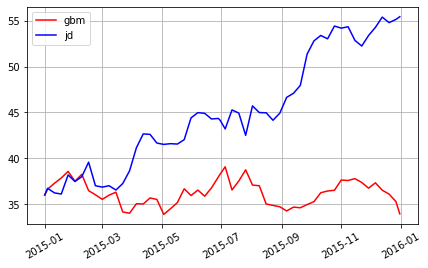

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(7, 4))
plt.plot(portfolio.time_grid, path_gbm, 'r', label='gbm')
plt.plot(portfolio.time_grid, path_jd, 'b', label='jd')
plt.xticks(rotation=30)
plt.legend(loc=0); plt.grid(True)   

In [28]:
correlations = [['gbm','jd',0.9]]

In [29]:
port_corr = derivatives_portfolio(name = 'portfolio',
                                 positions = positions,
                                 val_env = val_env,
                                 assets = underlyings,
                                 correlations = correlations,
                                 fixed_seed = True)

In [30]:
port_corr.get_statistics()

,name,quant.,value,curr.,pos_value,pos_delta,pos_vega
0,am_put_pos,3,4.619792,EUR,13.859376,-1.9284,40.7187
1,eur_call_pos,5,2.888685,EUR,14.443425,3.4775,43.6220


In [31]:
path_gbm = port_corr.underlying_objects['gbm'].get_instrument_values()[:, path_no]
path_jd = port_corr.underlying_objects['jd'].get_instrument_values()[:, path_no]

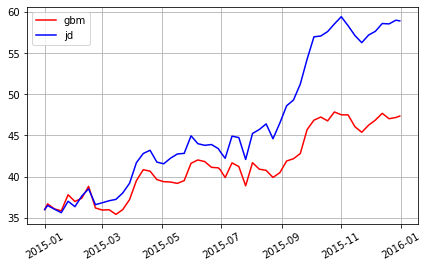

In [32]:
plt.figure(figsize=(7, 4))
plt.plot(portfolio.time_grid, path_gbm, 'r', label='gbm')
plt.plot(portfolio.time_grid, path_jd, 'b', label='jd')
plt.xticks(rotation=30)
plt.legend(loc=0); plt.grid(True)

각 옵션 포지션의 현재 가치 

In [33]:
pv1 = 5 * port_corr.valuation_objects['eur_call_pos'].present_value(full=True)[1]
pv1

array([ 0.        , 40.46758828, 24.54420555, ...,  0.        ,
        6.5125118 ,  8.18851653])

In [34]:
pv2 = 3 * port_corr.valuation_objects['am_put_pos'].present_value(full=True)[1]
pv2

array([22.33631582, 12.1476107 , 20.33098087, ..., 22.01996731,
       12.9969704 ,  0.        ])

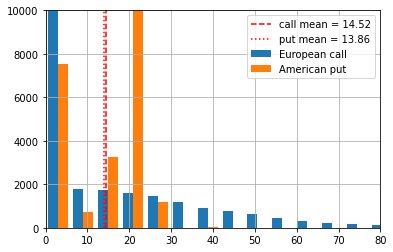

In [35]:
# 두 포지션 분포 비교
plt.hist([pv1, pv2], bins=25,
label=['European call', 'American put']);
plt.axvline(pv1.mean(), color='r', ls='dashed',
            lw=1.5, label='call mean = %4.2f' % pv1.mean())
plt.axvline(pv2.mean(), color='r', ls='dotted',
            lw=1.5, label='put mean = %4.2f' % pv2.mean())
plt.xlim(0, 80); plt.ylim(0, 10000)
plt.grid(); plt.legend()

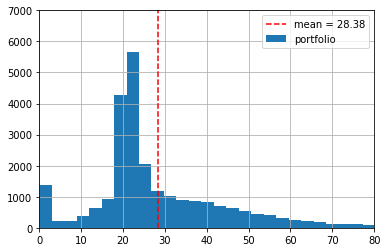

In [36]:
#포폴 현재가치 분포
pvs = pv1 + pv2
plt.hist(pvs, bins=50, label='portfolio');
plt.axvline(pvs.mean(), color='r', ls='dashed',
            lw=1.5, label='mean = %4.2f' % pvs.mean())
plt.xlim(0, 80); plt.ylim(0, 7000)
plt.grid(); plt.legend()

In [37]:
#> call + put되어서 서로 상쇄된 것을 볼 수 있음.

In [38]:
pvs.std() #상관관계 있는 포폴 편차

16.958325400506318

In [39]:
#상관관계 없는 포폴 편차
pv1 = 5 * portfolio.valuation_objects['eur_call_pos'].present_value(full=True)[1]
pv2 = 3 * portfolio.valuation_objects['am_put_pos'].present_value(full=True)[1]
(pv1 + pv2).std()

22.862366370089898